<a href="https://colab.research.google.com/github/AgainstEntropy/ECE-GY-6143-ML/blob/main/5_logistic_regression_in_depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Logistic regression in depth
============================

*Fraida Fund*

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
sns.set_style("white")

from sklearn.linear_model import LogisticRegression

# for 3d plots
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d

Basic logistic regression
-------------------------

### Data for binary classification

In [ ]:
n_samples = 1000
w_true = [-1, 1.2, 1]
sigma = 0.1
plot_colors = np.array(sns.color_palette().as_hex())

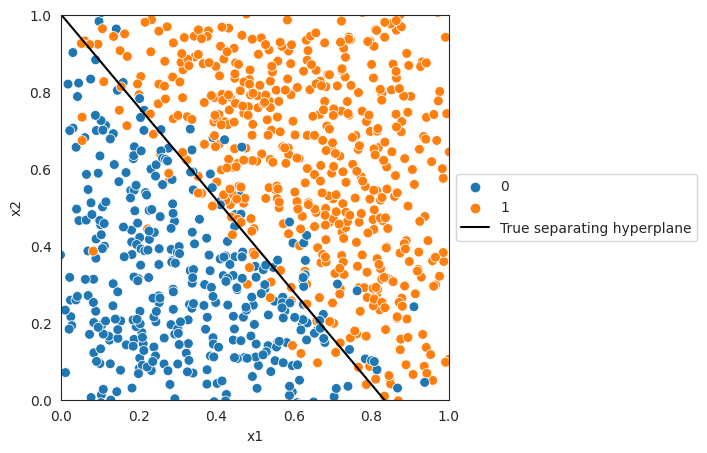

In [ ]:
# Generate training data
X = np.random.uniform(0, 1, size=(n_samples,2))
y = np.array(w_true[0]+w_true[1]*X[:,0]+w_true[2]*X[:,1] >= 0).astype(int)

# Add some noise?
X = X + sigma*np.random.randn(X.shape[0]*X.shape[1]).reshape(X.shape[0], X.shape[1])

# Figure formatting stuff
fig = plt.figure(figsize=(5,5))
plt.xlim(0,1);
plt.ylim(0,1);
plt.xlabel('x1');
plt.ylabel('x2')

# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                s=50, edgecolor='white');
x_true = np.linspace(0, 1)
y_true =  -(x_true * w_true[1] + w_true[0])/w_true[2]
sns.lineplot(x=x_true, y=y_true, color='black', label='True separating hyperplane');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

In [ ]:
y.shape

(1000,)

### Learning weights using gradient descent

The logistic regression learns the coefficient vector $w$ to minimize the loss function

$$L(w) = \sum_{i=1}^n - \left( y_i \log \frac{1}{1 + e^{- \langle w, x_i \rangle}} + (1 - y_i) \log \frac{e^{- \langle w, x_i \rangle}}{1 + e^{- \langle w, x_i \rangle}} \right) $$

(Assume that the data matrix has a column of 1s at the beginning, so that the intercept can be learned the same way as the other coefficients).

We can use gradient descent to learn the intercept and coefficient vector, using the gradient update rule

$$w_{k+1} = w_k + \alpha \sum_{i=1}^n (y_i - \frac{1}{1 + e^{-\langle w,x_i \rangle}}) x_i ,$$

In [ ]:
X_aug = np.hstack((np.ones((n_samples, 1)), X))

In [ ]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

In [ ]:
def cross_entropy_loss(w, X, y):
  p_pred = sigmoid(np.dot(X,w))
  loss_pos = y*np.log(p_pred)
  loss_neg = (1-y)*np.log(1-p_pred)
  return np.sum(-1*(loss_pos + loss_neg))

In [ ]:
def gd_step(w, X, y, lr):
  p_pred = sigmoid(np.dot(X,w))
  gradient = np.dot(X.T, y - p_pred)
  w = w + lr * gradient
  l = cross_entropy_loss(w,X,y)
  return w, l, gradient

In [ ]:
itr = 20000
lr = 0.005
tol = 0.01
w_init = np.random.randn(3)
print(w_init)

[ 1.42390485 -0.07567426  0.76682272]


In [ ]:
w_steps = np.zeros((itr, len(w_init)))
l_steps = np.zeros(itr)
grad_steps =  np.zeros((itr, len(w_init)))
stop = 0

w_star = w_init
for i in range(itr):
  w_star, loss, grad = gd_step(w_star, X_aug, y, lr)
  w_steps[i] = w_star
  l_steps[i] = loss
  grad_steps[i] = grad
  if np.linalg.norm(grad, ord=1) <= tol:
    print("Stopping gradient descent at iteration %d" % i)
    stop = i
    break
  stop = i

Stopping gradient descent at iteration 2840


In [ ]:
print(w_star)

[-11.23772199  13.36019666  11.46135388]


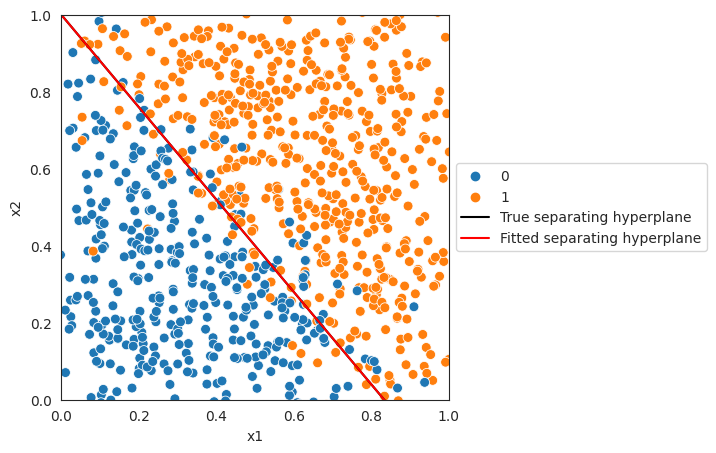

In [ ]:
# Figure formatting stuff
fig = plt.figure(figsize=(5,5))
plt.xlim(0,1);
plt.ylim(0,1);
plt.xlabel('x1');
plt.ylabel('x2')

# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                s=50, edgecolor='white');
x_true = np.linspace(0, 1)
y_true =  -(x_true * w_true[1] + w_true[0])/w_true[2]
sns.lineplot(x=x_true, y=y_true, color='black', label='True separating hyperplane');
y_fit =  -(x_true * w_star[1] + w_star[0])/w_star[2]
sns.lineplot(x=x_true, y=y_true, color='red', label='Fitted separating hyperplane');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

Why does the logistic regression choose *this* version of the separating hyperplane?

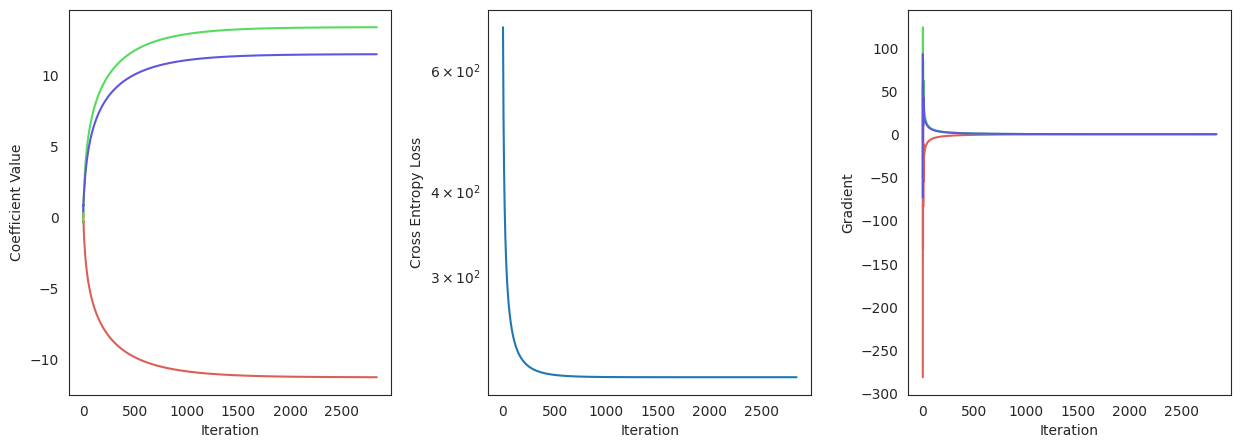

In [ ]:
colors = sns.color_palette("hls", len(w_star))
plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1);
for n in range(len(w_star)):
  sns.lineplot(x=np.arange(stop), y=w_steps[:stop,n], color=colors[n]);
plt.xlabel("Iteration");
plt.ylabel("Coefficient Value");

plt.subplot(1,3, 2);
sns.lineplot(x=np.arange(stop), y=l_steps[0:stop]);
plt.yscale("log")
plt.xlabel("Iteration");
plt.ylabel("Cross Entropy Loss");

plt.subplot(1,3,3);
for n in range(len(w_star)):
  sns.lineplot(x=np.arange(stop), y=grad_steps[:stop,n], color=colors[n]);
plt.xlabel("Iteration");
plt.ylabel("Gradient");

### Computing conditional probabilities

The logistic regression learns weights, then for each point $x_{\text{test}}$, it computes a conditional probability

$$P(y_{\text{test}} =1 | x = x_{\text{test}}) =  \frac{1}{1 + e^{-z}} $$

where $z = w_0 + w_1 x_1 + w_2 x_2$.

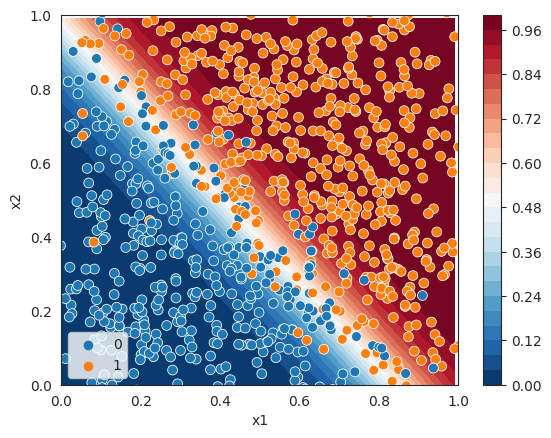

In [ ]:
# Define the probability contours
xx, yy = np.mgrid[0:1:.01, 0:1:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
#z = clf.intercept_ + np.dot(grid, clf.coef_.T)
z = w_star[0] + np.dot(grid, w_star[1:])
probs = 1/(1+np.exp(-z)).reshape(xx.shape)

# Figure formatting stuff
fig = plt.figure()
plt.xlim(0,1);
plt.ylim(0,1);
plt.xlabel('x1');
plt.ylabel('x2')


# Plot conditional probabilities
contours = plt.contourf(xx, yy, probs, 25, cmap="RdBu_r",
                      vmin=0, vmax=1);
fig.colorbar(contours)

# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                s=50, edgecolor='white');

Then, we can define a threshold. A common choice is 0.5, but we can choose any threshold we like, depending on the *cost* of different types of mistakes.

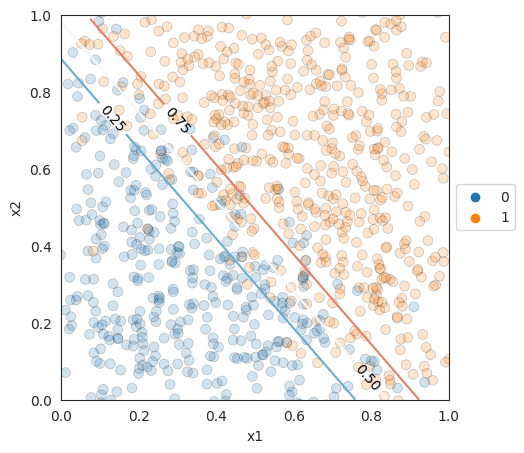

In [ ]:
# Figure formatting stuff
fig = plt.figure(figsize=(5,5))
plt.xlim(0,1);
plt.ylim(0,1);
plt.xlabel('x1');
plt.ylabel('x2')

# Plot conditional probabilities
contours = plt.contour(xx, yy, probs, levels=[0.25, 0.5, 0.75], cmap="RdBu_r",
                      vmin=0, vmax=1);
plt.clabel(contours, colors='black', inline=True, fontsize=10)

# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                s=50, edgecolor='black', alpha=0.2);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

Which threshold would you choose:

-   If you care most about overall accuracy (ratio of correct predictions to total predictions)?

    -  0.5

-   If you care most about avoiding false positives (labeling a point as positive, when it belongs to the negative class)?

    -  0.75

-   If you care most about avoiding false negatives (labeling a point as negative, when it belongs to the positive class)?

    -  0.25

Things to try:

-   What happens as we increase $\sigma$?

This tradeoff is often visualized using the *receiver operating characteristic* and the overall performance of the classifier is evaluated using the *area under the \[ROC\] curve*.

In [ ]:
y_hat = sigmoid(np.dot(X_aug,w_star))

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, y_hat)
roc_auc = auc(fpr, tpr)

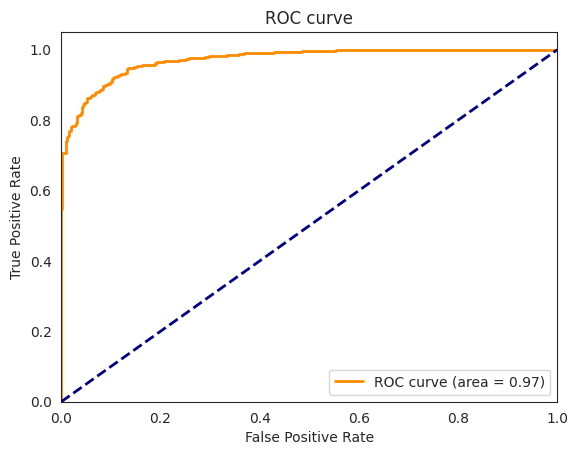

In [ ]:
plt.figure();
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC curve');
plt.legend(loc="lower right");

### Using sklearn

Let us create a Logistic Regression classifier using `sklearn`, and see if it learns the same intercept and coefficient.

Like other `sklearn` models, we train the Logistic Regression using its `fit()` method and then we can predict values using `predict()`. We can also get the conditional probabilities using `predict_proba()`.

In [ ]:
clf = LogisticRegression(penalty='none',
                         tol=0.01, solver='saga')
clf.fit(X, y)
print(clf.intercept_, clf.coef_)

[-10.9659629] [[13.02699515 11.16494038]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


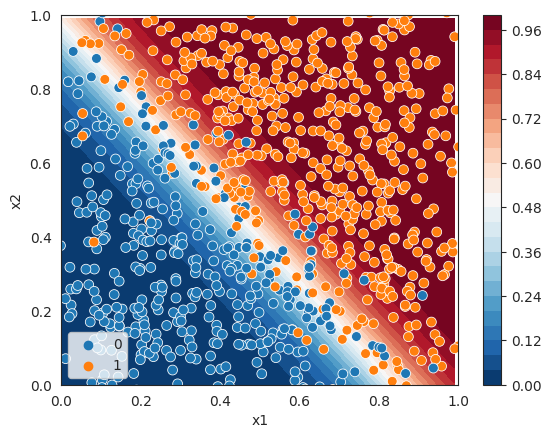

In [ ]:
# Define the probability contours
xx, yy = np.mgrid[0:1:.01, 0:1:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

# Figure formatting stuff
fig = plt.figure()
plt.xlim(0,1);
plt.ylim(0,1);
plt.xlabel('x1');
plt.ylabel('x2')

# Plot conditional probabilities
contours = plt.contourf(xx, yy, probs, 25, cmap="RdBu_r",
                      vmin=0, vmax=1);
fig.colorbar(contours)

# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                s=50, edgecolor='white');

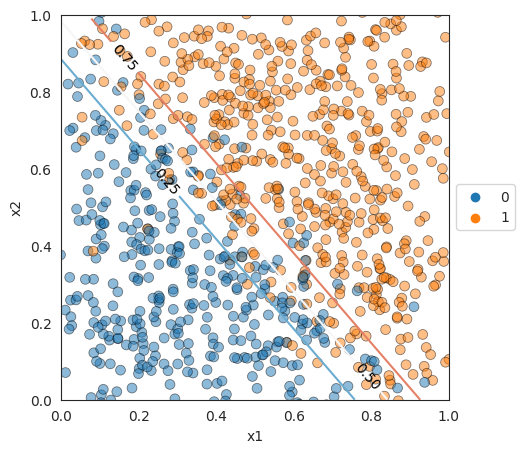

In [ ]:
# Figure formatting stuff
fig = plt.figure(figsize=(5,5))
plt.xlim(0,1);
plt.ylim(0,1);
plt.xlabel('x1');
plt.ylabel('x2')

# Plot conditional probabilities
contours = plt.contour(xx, yy, probs, levels=3, cmap="RdBu_r",
                      vmin=0, vmax=1);
plt.clabel(contours, colors='black', inline=True, fontsize=10)

# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                s=50, edgecolor='black',  alpha=0.5);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

Data with non-linear decision boundary
--------------------------------------

As with linear regression, we can use a logistic regression to classify data with a boundary that is linear, if we can find a transformed feature space with a linear boundary between classes.

Consider the following data with a polynomial boundary:

In [ ]:
n_samples = 1000
sigma = 0
coefs=np.array([0.3, 1, -1.5, -2])
xrange=[-1,1]

In [ ]:
def generate_polynomial_classifier_data(n=100, xrange=[-1,1], coefs=[1,0.5,0,2], sigma=0.5):
  x = np.random.uniform(xrange[0], xrange[1], size=(n, 2))
  ysep = np.polynomial.polynomial.polyval(x[:,0],coefs)
  y = (x[:,1]>ysep).astype(int)
  x[:,0] = x[:,0] + sigma * np.random.randn(n)
  x[:,1] = x[:,1] + sigma * np.random.randn(n)
  return x, y

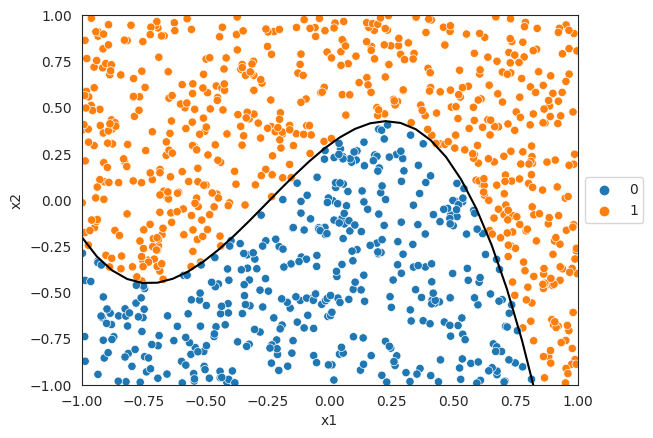

In [ ]:
X, y = generate_polynomial_classifier_data(n=n_samples, xrange=xrange, coefs=coefs, sigma=sigma)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

plt.xlabel('x1');
plt.ylabel('x2')


# Plot true function
xtrue = np.linspace(-1, 2)
ytrue = np.polynomial.polynomial.polyval(xtrue,coefs)
sns.lineplot(x=xtrue, y=ytrue, color='black')
plt.xlim((xrange[0], xrange[1]));
plt.ylim((xrange[0], xrange[1]));

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

Our logistic regression can only learn linear boundaries, so it does not do very well on this data:

In [ ]:
clf = LogisticRegression(penalty='none',
                         tol=0.01, solver='saga')
clf.fit(X, y)
clf.score(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.794

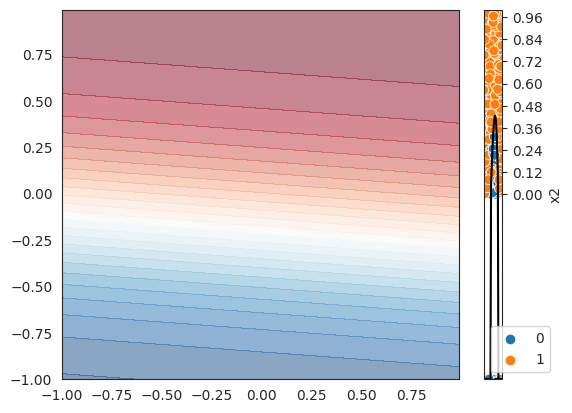

In [ ]:
# Define the probability contours
xx, yy = np.mgrid[-1:1:.01, -1:1:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

# Plot conditional probabilities
contours = plt.contourf(xx, yy, probs, 25, cmap="RdBu_r",
                      vmin=0, vmax=1, alpha=0.5);
fig.colorbar(contours)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linestyles='dashed',
                      vmin=0, vmax=1);

# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                s=50, edgecolor='white');


sns.lineplot(x=xtrue, y=ytrue, color='black')

plt.xlim((xrange[0], xrange[1]));
plt.ylim((xrange[0], xrange[1]));
plt.xlabel('x1');
plt.ylabel('x2');


(Here, the dashed black line shows the decision boundary, and the solid black line shows the true boundary.)

But if we add $x_1^2$, $x_1^3$ to our model, then we can create a linear boundary between classes using a linear combination of features:

In [ ]:
dmax = 3

X_trans = np.hstack( [X[:,0].reshape(-1,1)**d for d in np.arange(0,dmax+1)] )
X_trans = np.hstack((X_trans, X[:,1].reshape(-1,1)))
X_trans.shape

(1000, 5)

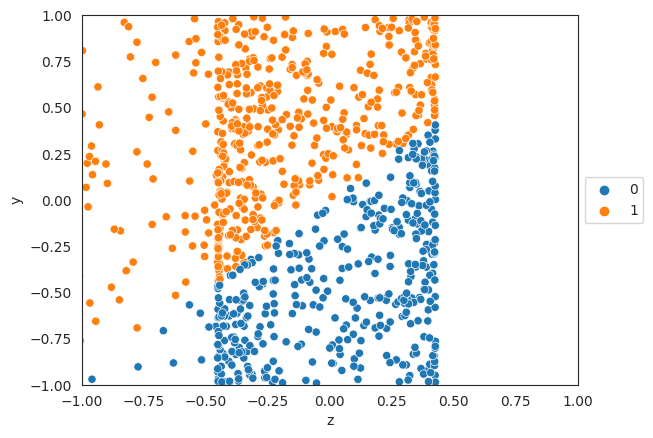

In [ ]:
sns.scatterplot(x=np.dot(X_trans[:,0:dmax+1], coefs.reshape(-1,1)).squeeze(), y=X_trans[:,-1], hue=y)
plt.xlabel('z')
plt.ylabel('y')
plt.xlim((xrange[0], xrange[1]));
plt.ylim((xrange[0], xrange[1]));

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

We can classify this data very well with a logistic regression on the transformed features:

In [ ]:
clf_trans = LogisticRegression(penalty='none',
                         tol=0.01, solver='saga')
clf_trans.fit(X_trans, y)
clf_trans.score(X_trans, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.99

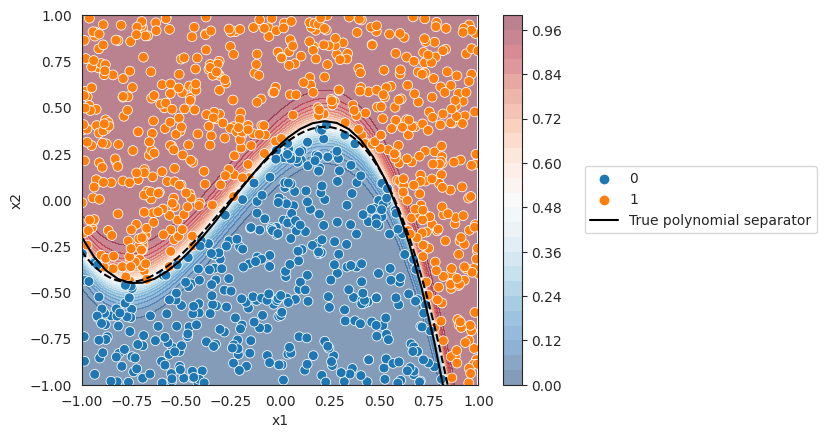

In [ ]:
# Define the probability contours
xx, yy = np.mgrid[-1:1:.01, -1:1:.01]
grid = np.hstack([xx.reshape(-1,1)**d for d in np.arange(0, dmax+1)])
grid = np.hstack([grid, yy.reshape(-1,1)])
probs = clf_trans.predict_proba(grid)[:, 1].reshape(xx.shape)

# Figure formatting stuff
fig = plt.figure()

# Plot conditional probabilities
contours = plt.contourf(xx, yy, probs, 25, cmap="RdBu_r",
                      vmin=0, vmax=1, alpha=0.5);
fig.colorbar(contours)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linestyles='dashed',
                      vmin=0, vmax=1);

# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                s=50, edgecolor='white');

sns.lineplot(x=xtrue, y=ytrue, color='black', label='True polynomial separator')

plt.xlim((xrange[0], xrange[1]));
plt.ylim((xrange[0], xrange[1]));
plt.xlabel('x1');
plt.ylabel('x2');
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1);

As with linear regression:

-   When there is under-modeling, adding transformed features can reduce bias.
-   However, adding features also increases variance.
-   We can use cross validation to choose a model that fits the data well but also generalizes.
-   We can add a regularization penalty to our loss function to reduce variance.